# Session 2: Cơ bản về Xử lý Ảnh (Image Processing Basics)

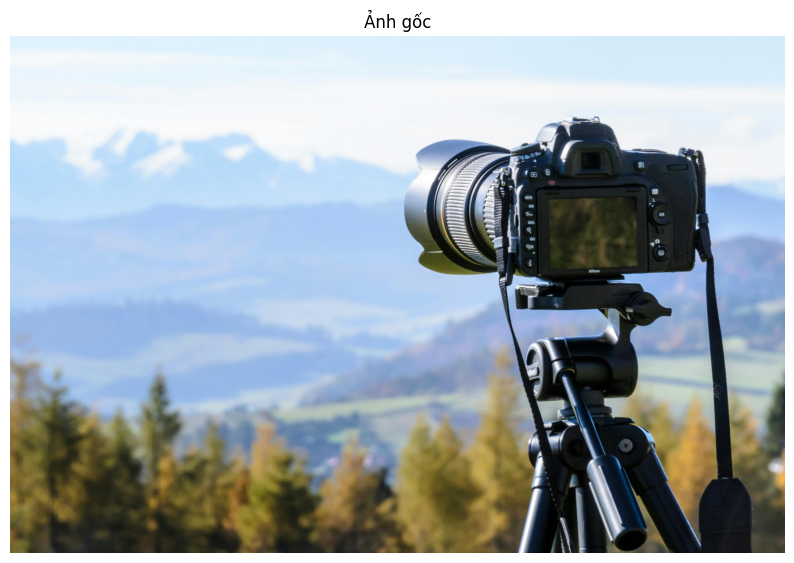

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Hàm hỗ trợ hiển thị ảnh bằng Matplotlib để có thể xem trực tiếp trong Notebook
def show_image(image, title="Image", cmap=None):
    plt.figure(figsize=(10, 8))
    if len(image.shape) == 3:
        # OpenCV dùng định dạng BGR, Matplotlib dùng RGB nên cần chuyển đổi
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, cmap='gray' if cmap is None else cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Đọc ảnh đầu vào từ máy tính
img_path = 'pexels-asphotograpy-212372.jpg'
img = cv2.imread(img_path)

if img is None:
    print("Không tìm thấy ảnh! Vui lòng kiểm tra đường dẫn.")
else:
    show_image(img, "Ảnh gốc")

## I. Toán Tử Điểm Ảnh (Pixel-wise Operators)

Các toán tử này tác động lên từng pixel một cách độc lập thông qua công thức:
$$g(x,y) = T(f(x,y))$$
Trong đó $f(x,y)$ là giá trị pixel cũ và $g(x,y)$ là giá trị pixel mới.

### 1 & 2. Thay đổi độ sáng và độ tương phản
Công thức tổng quát: 
$$g(x,y) = \alpha \cdot f(x,y) + \beta$$
- **$\alpha$ (Contrast):** Nếu $\alpha > 1$, độ tương phản tăng; $0 < \alpha < 1$, độ tương phản giảm.
- **$\beta$ (Brightness):** Cộng thêm một giá trị để tăng/giảm độ sáng.

*Lưu ý:* Khi cộng hoặc nhân, giá trị pixel có thể vượt quá dải [0, 255]. Chúng ta cần dùng `np.clip` để cắt các giá trị này.

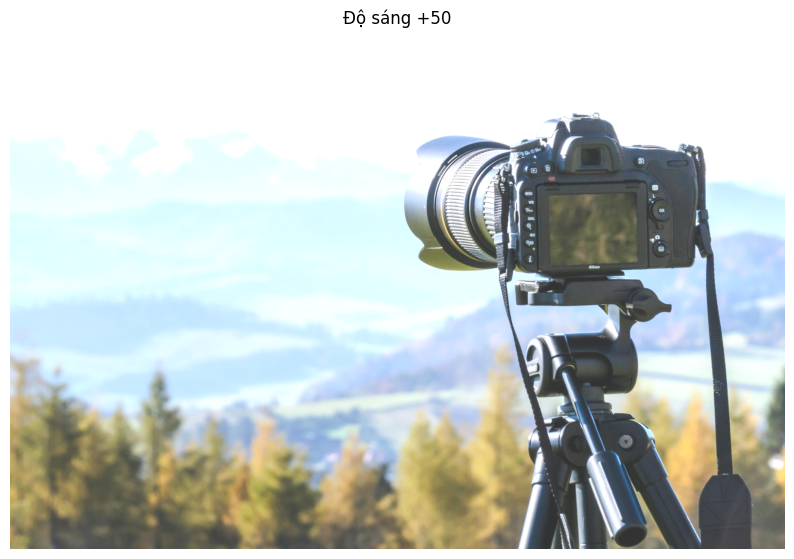

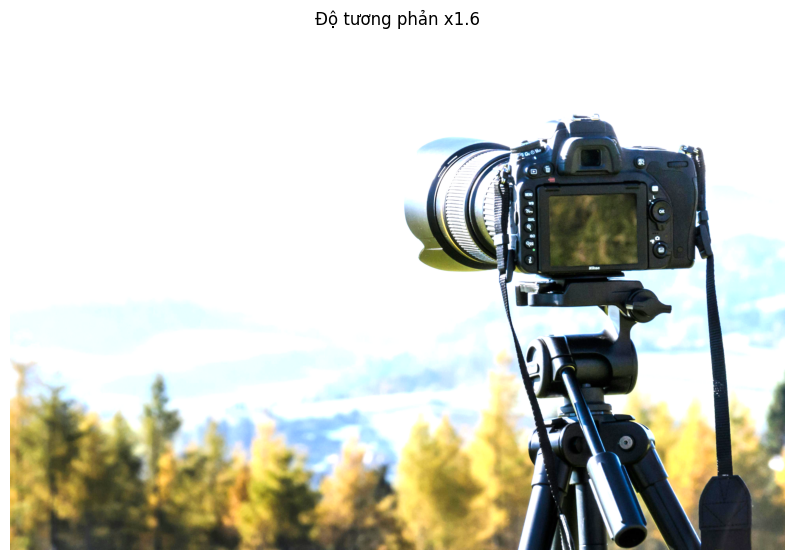

In [2]:
# 1. Thay đổi độ sáng (Brightness)
beta = 50 # Tăng độ sáng thêm 50 đơn vị
bright_img = np.clip(img.astype(np.int32) + beta, 0, 255).astype(np.uint8)

# 2. Thay đổi độ tương phản (Contrast)
alpha = 1.6 # Tăng tương phản lên 1.6 lần
contrast_img = np.clip(img.astype(np.float32) * alpha, 0, 255).astype(np.uint8)

show_image(bright_img, f"Độ sáng +{beta}")
show_image(contrast_img, f"Độ tương phản x{alpha}")

### 3. Biến đổi âm bản (Negative Transformation)
Phép biến đổi này đảo ngược cường độ sáng của ảnh. 
$$s = L - 1 - r$$
Với ảnh 8-bit, $L = 256$, công thức trở thành $s = 255 - r$. Kỹ thuật này thường được dùng để làm nổi bật các chi tiết màu sáng trên nền tối, đặc biệt trong ảnh y khoa.

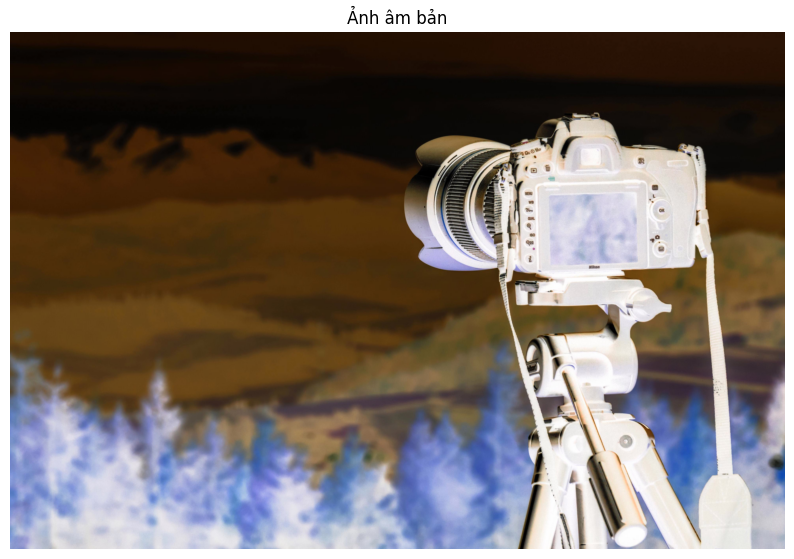

In [3]:
negative_img = 255 - img
show_image(negative_img, "Ảnh âm bản")

### 4. Cắt ngưỡng (Thresholding)
Đây là phương pháp đơn giản nhất để phân đoạn ảnh (segmentation), chuyển ảnh xám thành ảnh nhị phân (đen trắng).
$$ 
g(x,y) = 
\begin{cases} 
255 & \text{nếu } f(x,y) > T \\
0 & \text{nếu } f(x,y) \le T 
\end{cases} 
$$
Trong đó $T$ là giá trị ngưỡng (threshold).

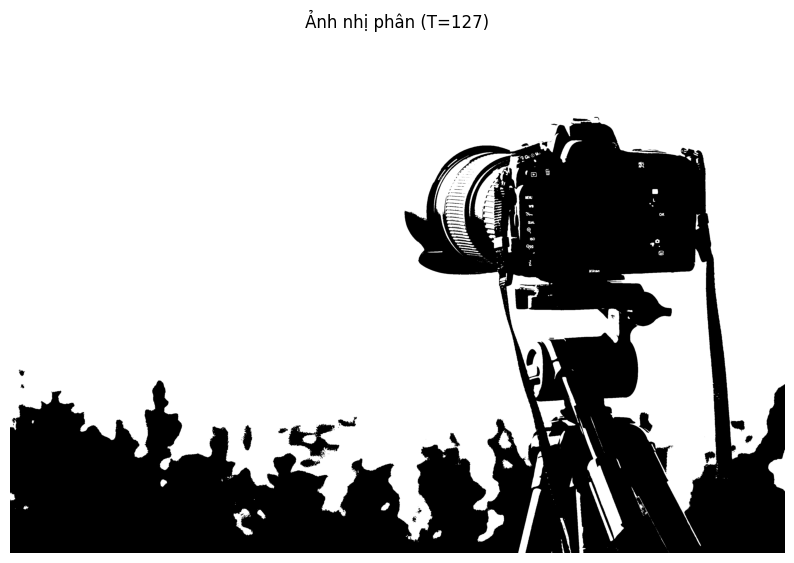

In [4]:
# Chuyển ảnh về mức xám (Grayscale)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Cắt ngưỡng với T = 127
threshold_value = 127
ret, thresh_img = cv2.threshold(gray_img, threshold_value, 255, cv2.THRESH_BINARY)

show_image(thresh_img, f"Ảnh nhị phân (T={threshold_value})", cmap='gray')

## II. Lọc Tuyến Tính (Linear Filtering)

Lọc tuyến tính dựa trên phép tích chập (convolution) giữa ảnh và một ma trận nhỏ gọi là **Kernel** (mặt nạ). Giá trị của một pixel mới được tính bằng tổng trọng số của các pixel trong vùng lân cận.

### 1. Lọc trung bình (Average Filter)
Kernel của bộ lọc trung bình có tất cả các giá trị bằng nhau và tổng bằng 1. Nó làm mờ ảnh bằng cách triệt tiêu các thay đổi đột ngột về cường độ (nhiễu).
Ví dụ Kernel 3x3:
$$ K = \frac{1}{9} \begin{bmatrix} 1&1&1 \\ 1&1&1 \\ 1&1&1 \end{bmatrix} $$

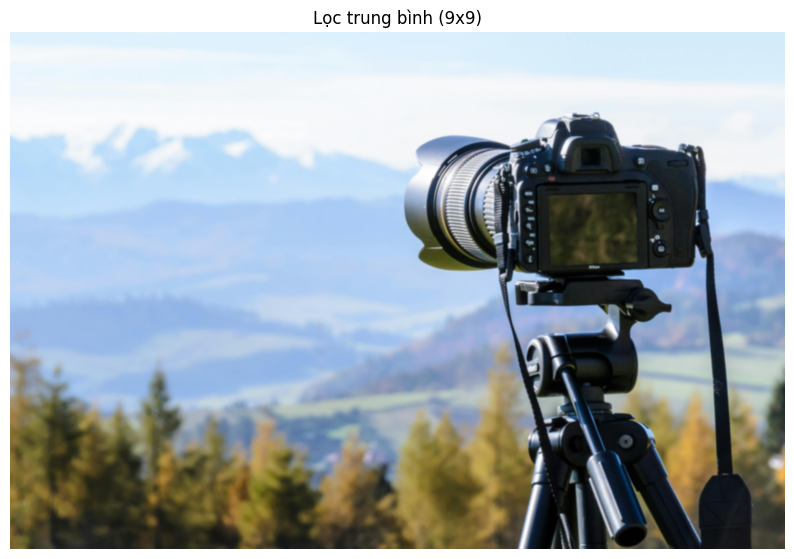

In [5]:
blur_img = cv2.blur(img, (9, 9))
show_image(blur_img, "Lọc trung bình (9x9)")

### 2. Lọc Gaussian (Gaussian Filter)
Thay vì trọng số bằng nhau như lọc trung bình, lọc Gaussian gán trọng số lớn hơn cho các pixel ở tâm mặt nạ theo phân phối chuẩn (Bell curve). Điều này giúp làm mờ ảnh một cách tự nhiên hơn và giữ lại cấu trúc tốt hơn so với lọc trung bình.

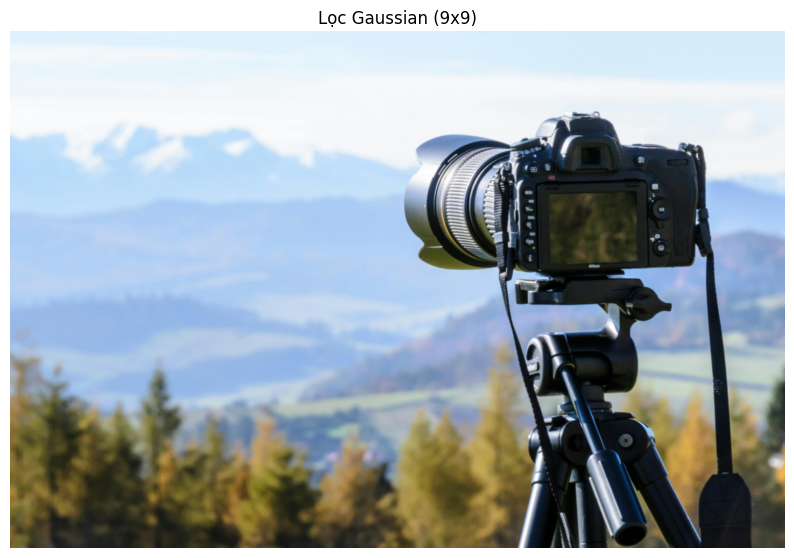

In [6]:
gaussian_img = cv2.GaussianBlur(img, (9, 9), 0)
show_image(gaussian_img, "Lọc Gaussian (9x9)")

### 3. Làm sắc nét (Sharpening)
Làm sắc nét là quá trình tăng cường sự tương phản tại các cạnh (nơi có sự thay đổi đột ngột về mức xám). Chúng ta sử dụng một Kernel có giá trị dương lớn ở tâm và các giá trị âm xung quanh để làm nổi bật các chi tiết cao tần.

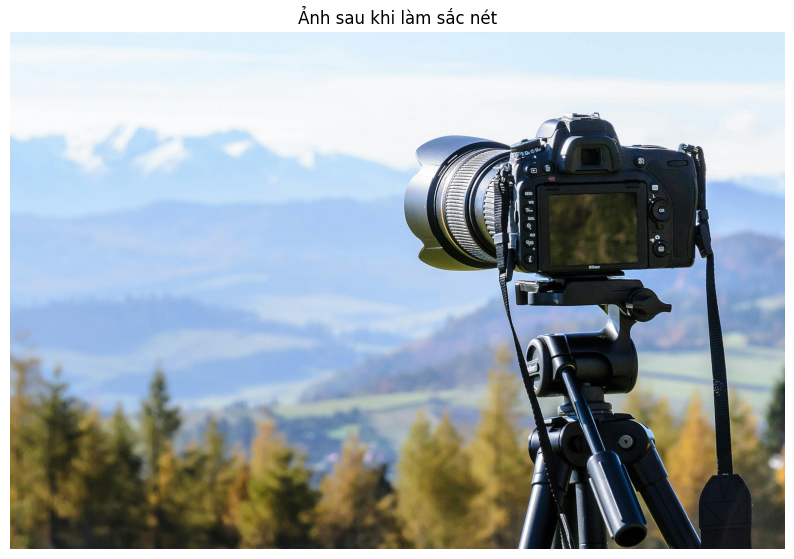

In [7]:
# Kernel làm sắc nét phổ biến
sharpen_kernel = np.array([[-1, -1, -1],
                           [-1,  9, -1],
                           [-1, -1, -1]])
sharpened_img = cv2.filter2D(img, -1, sharpen_kernel)
show_image(sharpened_img, "Ảnh sau khi làm sắc nét")

## III. Bài tập nâng cao (Advanced Exercises)

### 1. Phát hiện cạnh (Edge Detection)
Cạnh là các vị trí trong ảnh có sự thay đổi cường độ sáng đột ngột. Để phát hiện cạnh, ta tính đạo hàm của ảnh.
- **Sobel:** Sử dụng hai kernel để tính xấp xỉ đạo hàm theo hướng X và Y. Nó có khả năng lọc nhiễu nhẹ.
- **Prewitt:** Tương tự Sobel nhưng sử dụng trọng số đơn giản hơn.

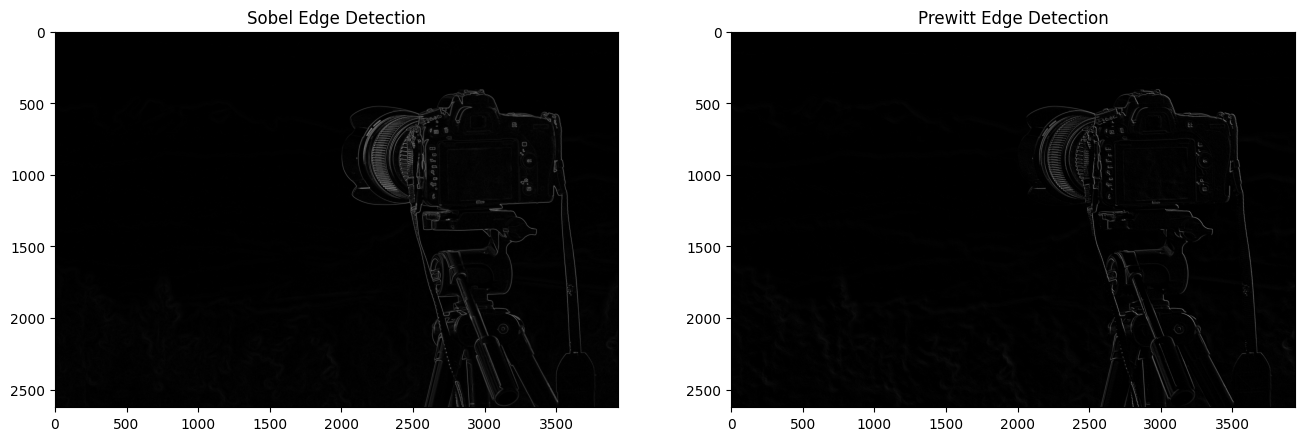

In [8]:
# Sobel
sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=3)
sobel_combined = cv2.magnitude(sobelx, sobely)

# Prewitt kernels (Thủ công)
kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
prewitt_x = cv2.filter2D(gray_img, -1, kernelx)
prewitt_y = cv2.filter2D(gray_img, -1, kernely)
prewitt_combined = cv2.addWeighted(prewitt_x, 0.5, prewitt_y, 0.5, 0)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1), plt.imshow(sobel_combined, cmap='gray'), plt.title('Sobel Edge Detection')
plt.subplot(1, 2, 2), plt.imshow(prewitt_combined, cmap='gray'), plt.title('Prewitt Edge Detection')
plt.show()

### 2. Tự thiết kế kernel (Custom Kernels)
Ngoài các kernel tiêu chuẩn, ta có thể thiết kế kernel cho các hiệu ứng nghệ thuật. 
Ví dụ: **Emboss** (Chạm nổi) tạo ra hiệu ứng 3D bằng cách tính toán sự khác biệt giữa các pixel đối diện qua tâm.

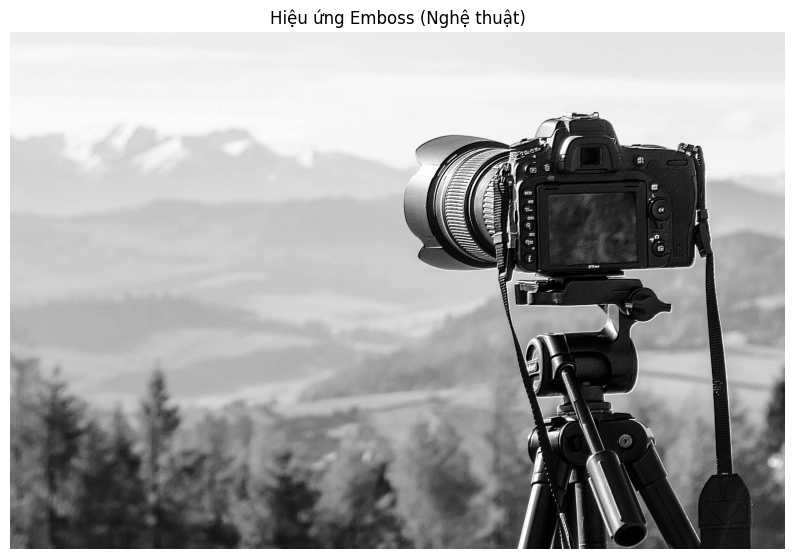

In [9]:
emboss_kernel = np.array([[-2, -1, 0],
                          [-1,  1, 1],
                          [ 0,  1, 2]])
emboss_img = cv2.filter2D(gray_img, -1, emboss_kernel)
show_image(emboss_img, "Hiệu ứng Emboss (Nghệ thuật)", cmap='gray')

### 3. Áp dụng lọc phi tuyến tính (Non-linear Filtering)
Khác với lọc tuyến tính, lọc phi tuyến tính không dựa trên tổng trọng số mà dựa trên các thuật toán logic.
- **Median Filter (Lọc trung vị):** Lấy giá trị trung vị trong vùng lân cận. Cực kỳ hiệu quả trong việc loại bỏ nhiễu "muối tiêu" (salt-and-pepper) mà vẫn giữ được cạnh.
- **Bilateral Filter (Lọc song phương):** Một bộ lọc làm mịn rất đặc biệt, nó xem xét cả khoảng cách về không gian và sự khác biệt về cường độ sáng. Kết quả là ảnh được làm mịn vùng phẳng nhưng giữ nguyên các cạnh sắc nét.

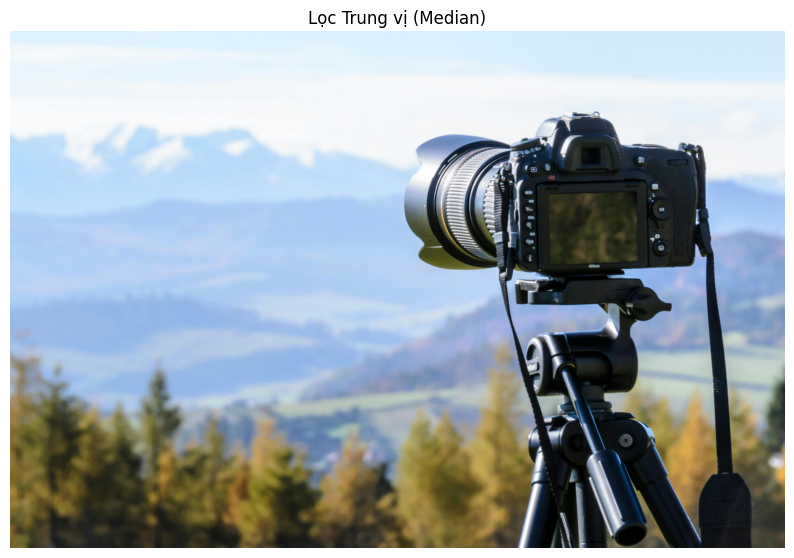

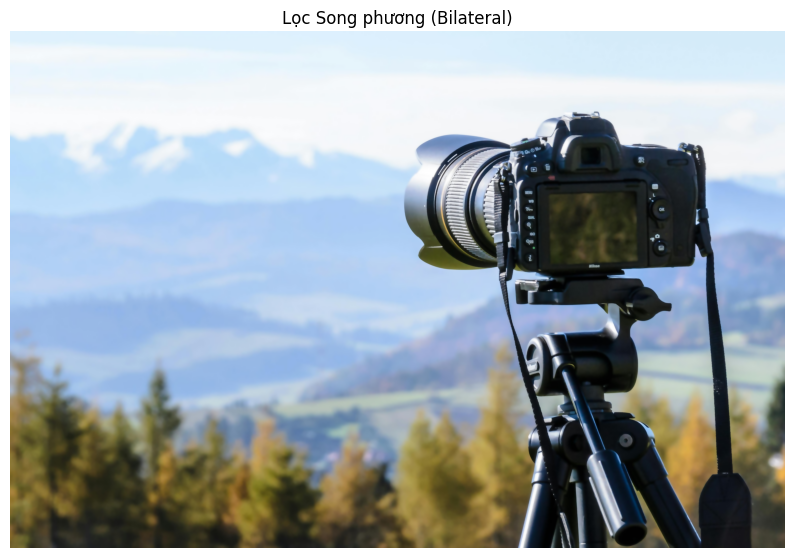

In [10]:
# Median Filter
median_img = cv2.medianBlur(img, 5)

# Bilateral Filter
bilateral_img = cv2.bilateralFilter(img, 15, 75, 75)

show_image(median_img, "Lọc Trung vị (Median)")
show_image(bilateral_img, "Lọc Song phương (Bilateral)")

## IV. Tổng kết và So sánh
Dưới đây là cái nhìn tổng quan về sự khác biệt giữa các phép lọc làm mịn.

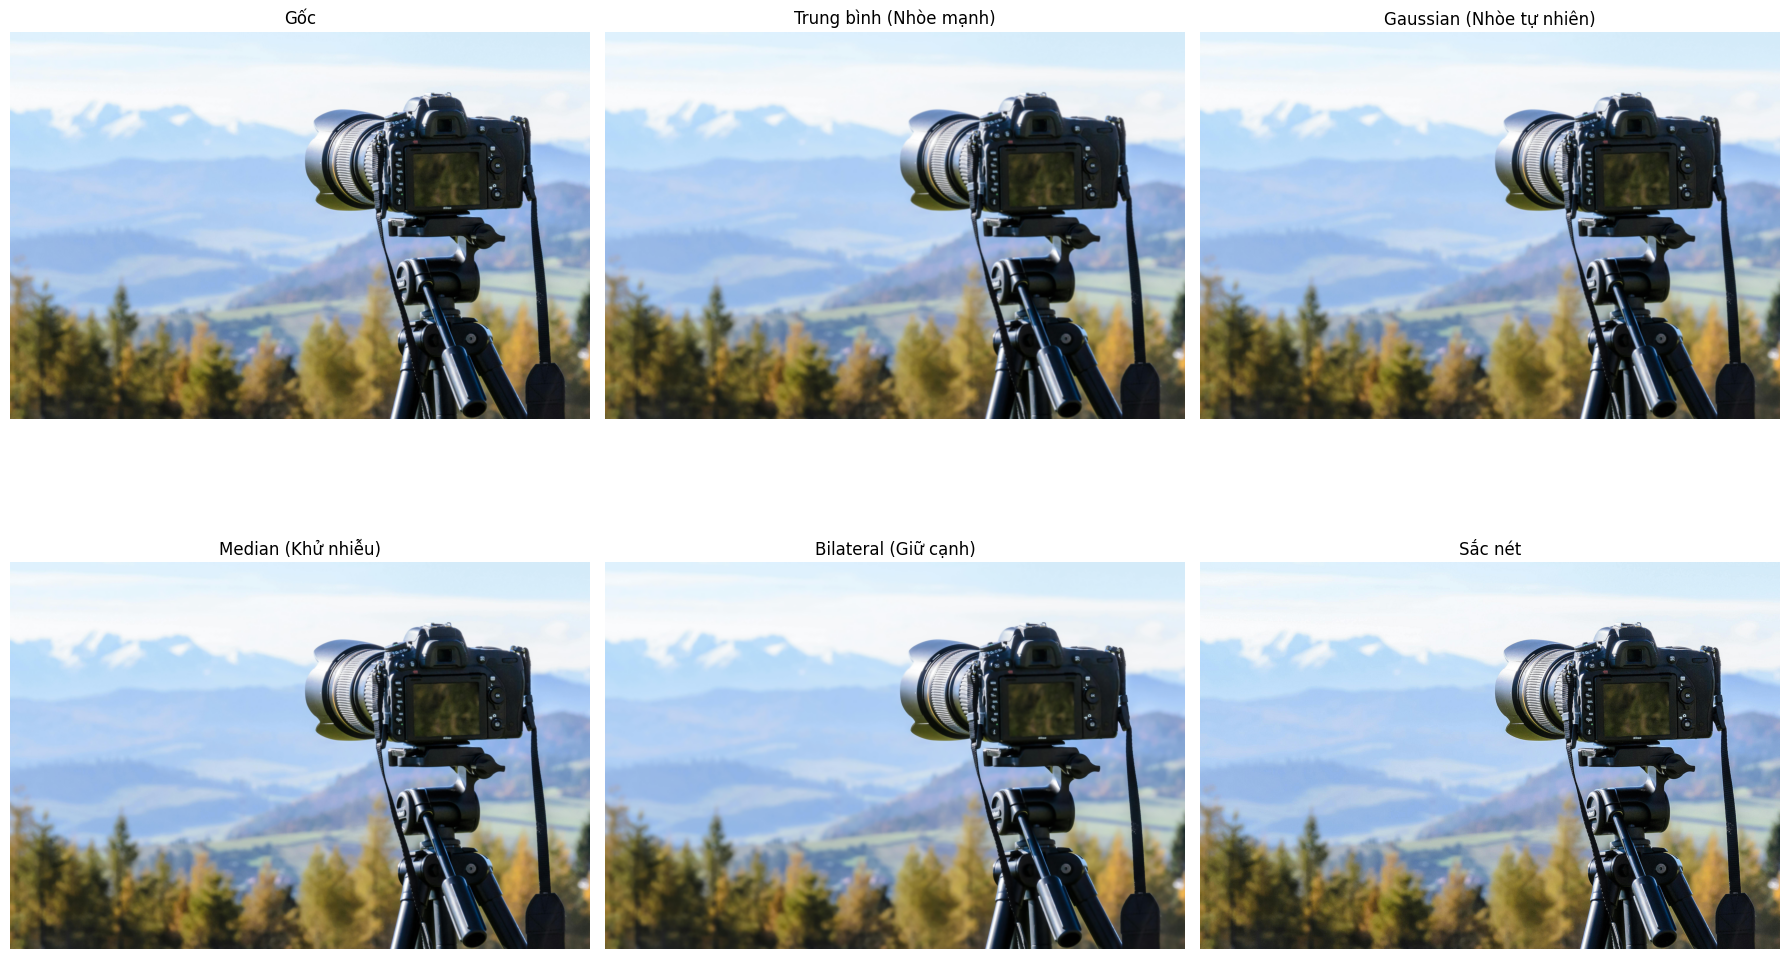

In [11]:
plt.figure(figsize=(18, 12))
titles = ['Gốc', 'Trung bình (Nhòe mạnh)', 'Gaussian (Nhòe tự nhiên)', 'Median (Khử nhiễu)', 'Bilateral (Giữ cạnh)', 'Sắc nét']
images = [img, blur_img, gaussian_img, median_img, bilateral_img, sharpened_img]

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()